# HW 9 - Investigating Chaotic systems with python


## Excercise 1

Recall the Holling-Tanner Model of an ecological system

*Plants*  
$\dot{x} = x(1-x) - \frac{a_1x}{1+b_1x}y$  

*Herbivores*  
$\dot{y} = \frac{a_1x}{1+b_1x}y - d_1y-\frac{a_2y}{1+b_2y}z$  

*Carnivores*  
$\dot{z} = \frac{a_2y}{1+b_2y}z - d_2z$


Simulate these equations for at least two sets of initial conditions that are less than 1% apart using the following parameters  
`a1 = 5`  
`b1 = 3`  
`a2 = 0.1`  
`b2 = 2`  
`d1 = 0.4`  
`d2 = 0.01`  

Plot the results as both a time series and trajectories. What eventually happens to the trajectories?

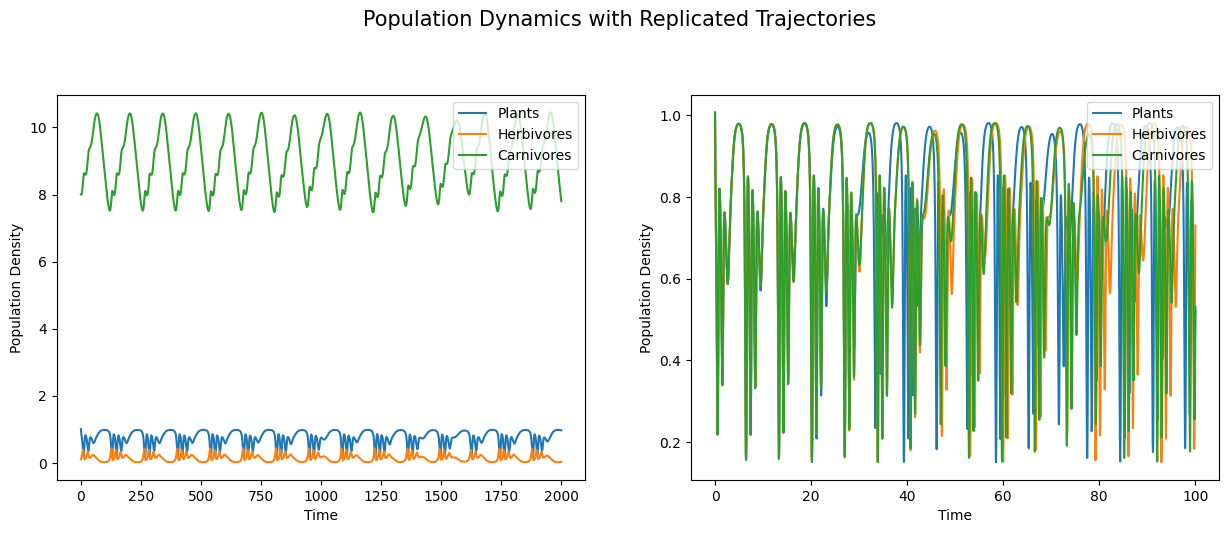

The trajectories diverge over time.


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def HT(state, t0, a1 = 5, a2 = 0.1, b1 = 3, b2 = 2, d1 = 0.4, d2 = 0.01):

    x = state[0]
    y = state[1]
    z = state[2]

    dxdt = x * (1 - x) - ((a1 * x)/(1 + (b1 * x))) * y
    dydt = (((a1 * x)/(1 + (b1 * x))) * y) - (d1 * y) - ((a2 * y)/(1 + (b2 * y))) * z
    dzdt = (((a2 * y)/(1 + (b2 * y))) * z) - (d2 * z)

    return [dxdt, dydt, dzdt]


t = np.linspace(0, 2000, 100000)
state0 = np.array([1, 0.1, 8])
state = odeint(HT, state0, t)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(t, state)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population Density')
axes[0].legend(('Plants', 'Herbivores', 'Carnivores'), loc='upper right')


N_trajectories = 3
t2 = np.linspace(0, 100, 100000)
state0 = np.array([1, 0.1, 8]) + 0.01*np.random.random((N_trajectories, 3))
state = np.asarray([odeint(HT, state0i, t)
                    for state0i in state0])

for i in range(N_trajectories):
    axes[1].plot(t2, state[i, :, 0])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Population Density')
axes[1].legend(('Plants', 'Herbivores', 'Carnivores'), loc='upper right')

plt.suptitle('Population Dynamics with Replicated Trajectories', fontsize=15, y=1.05)
plt.show()

print('The trajectories diverge over time.')

## Excercise 2
Recall that the concept of "sensitivity to initial conditions" can be given a precise definition.

Suppose $m_0$ and $n_0$ are two sets of initial conditions for the Holling-Tanner system and $d(m_0,n_0)$ is the distance between those points.

In the Holling-Tanner system $m_0$ and $n_0$ are points in 3-dimensional space, so the distance between them can be calculated using the standard formula for Euclidean distance:

$d(m,n) = \sqrt{(x_m-x_n)^2+(y_m-y_n)^2+(z_m-z_n)^2}$

After time $t$ the points $m_0$ and $n_0$ have been integrated to $m_t$ and $n_t$. Sensitivity dependance says that $d(m_t, n_t)$ grows exponentially with time with different levels of sensitivity being associated with different values of the lyapunov exponentn $\lambda$, such that  

$d(m_t, n_t) = e^{\lambda t}d(m_0,n_0)$  

Approximate the lyapunov exponent for the Holling-Tanner system using the parameters from Excercise 1. Show your work. 

In [60]:
from scipy.spatial import distance

def compute_lyap_dst(state):
    dst = np.zeros(state.shape[1])

    for i in range(state.shape[1]):

        dst_mtrx = distance.cdist(state[:, i, :], state[:, i, :], metric='euclidean')
        min_dst = np.min(dst_mtrx[np.nonzero(dst_mtrx)])
        dst[i] = min_dst

    log_dst = np.log(dst)
    time = np.arange(state.shape[1])
    slope, int = np.polyfit(time, log_dst.squeeze(), 1)

    lyapunov_exp = slope / state.shape[1]

    dst = np.exp(lyapunov_exp * time) * dst[0]

    return dst.T, lyapunov_exp


dst, lyapunov_exp = compute_lyap_dst(state)
print(f'Lyapunov exponent: {lyapunov_exp:.3e}')

Lyapunov exponent: 3.676e-10


## Excercise 3

Plot the Lorenz Map of the herbivores in the Holling-Tanner system using the abovementioned parameters.  

What happens at an Nth peak height of ~0.29? What does it represent?



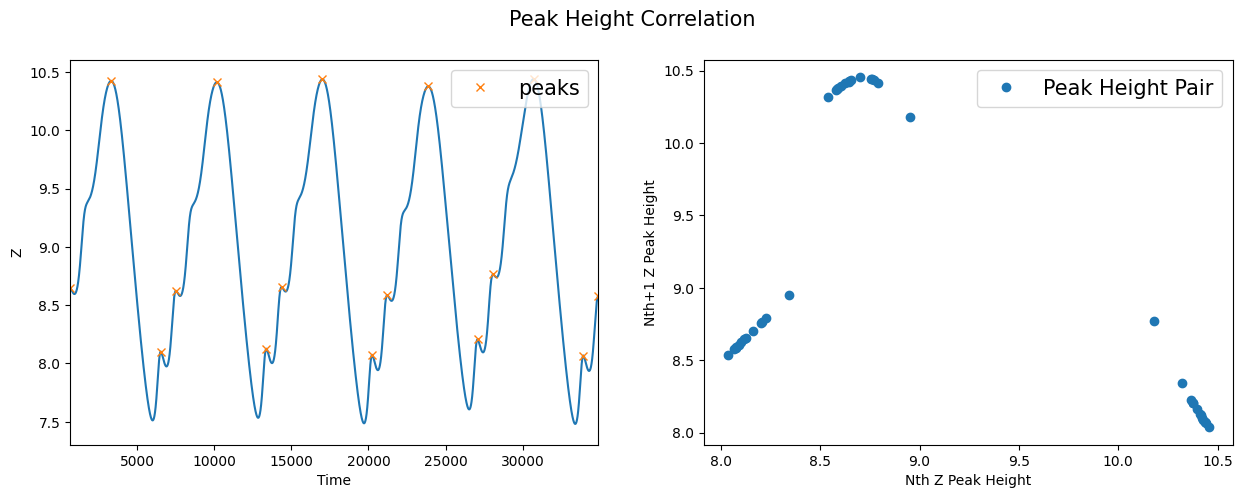

In [120]:
from scipy.signal import find_peaks

z = state[0, :, 2]

peaks, _ = find_peaks(z)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(z)
axes[0].plot(peaks, z[peaks], 'x', label='peaks')
axes[0].legend(loc='upper right', fontsize=15)
axes[0].set_xlim(peaks[0], peaks[15])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Z')

firstPeak = z[peaks[:-1]]
secondPeak = z[peaks[1:]]

peak_idx = np.where(np.isclose(firstPeak, 0.29, rtol=0.01))[0]

axes[1].plot(firstPeak, secondPeak, 'o', label = 'Peak Height Pair')
axes[1].plot(firstPeak[peak_idx], secondPeak[peak_idx], 'o', color='orange')
axes[1].set_ylabel('Nth+1 Z Peak Height')
axes[1].set_xlabel('Nth Z Peak Height')
axes[1].legend(loc='upper right', fontsize=15)
fig.suptitle('Peak Height Correlation', fontsize=15)
plt.show()


## Excercise 4 (Extra Credit)
Demonstrate and explain why chaos can only occur in a 3D system. 
Show what you would have to do to the FitzHugh Nagumo System to bring it into a chaotic regime.
What are the tradeoffs between for an open system that must be functional (e.g. something in biology) in being almost but not quite chaotic as it approaches a parameter set that gives a lyapunov coefficient greater than 0.

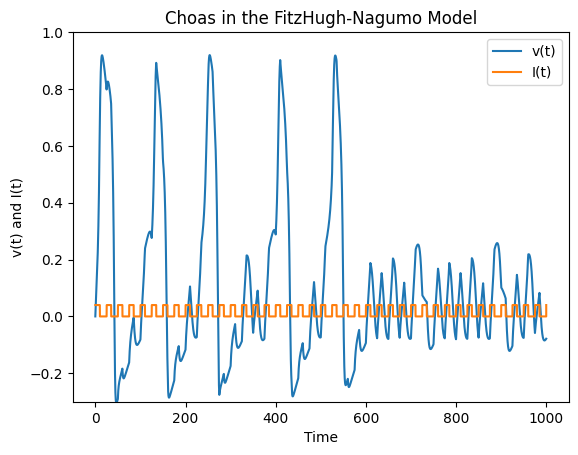

In [113]:

def fitzHughNaguma(state, t):
    v = state[0]
    w = state[1]

    dv = -v * (v - a) * (v - 1) - w + pulse(t, tOn, tOff, IOn, IOff)
    dw = eps * (v - gamma * w)

    return(dv, dw)

def pulse(t, tOn, tOff, uOn, uOff):

    if (t%(tOn+tOff)) < tOn:
        I = uOn

    elif (t%(tOn+tOff) >= tOn):
        I = uOff

    return I

def computeI(t):
    I = np.zeros(len(t))
    for i in np.arange(0, len(t), 1):
        I[i] = pulse(t[i], tOn, tOff, IOn, IOff)

    return I
    

eps = 0.01
a = 0.1
gamma = 2

tOn = 10
tOff = 15
IOn = 0.04
IOff = 0

t = np.linspace(0, 1000, 100000)
state0 = [0, 0]
state = odeint(fitzHughNaguma, state0, t)

plt.plot(t, state[:,0], label='v(t)')
plt.plot(t, computeI(t), label='I(t)')
plt.ylim(-.3, 1)
plt.xlabel('Time')
plt.ylabel('v(t) and I(t)')
plt.title('Choas in the FitzHugh-Nagumo Model')
plt.legend()
plt.show()


Who did you work with: